# Importing the dataset

In [1]:
!git clone https://github.com/kumailht/diabetic-retinopathy

Cloning into 'diabetic-retinopathy'...
remote: Enumerating objects: 5626, done.
remote: Total 5626 (delta 0), reused 0 (delta 0), pack-reused 5626
Receiving objects: 100% (5626/5626), 757.22 MiB | 26.03 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (2784/2784), done.


# Importing Libraries

In [2]:
!pip install -q efficientnet
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [3]:
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2

import os
import numpy as np
import itertools
import random

from collections import Counter

from glob import iglob

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
import gdown



# Setting The Constant Hyperparameters

In [4]:

BASE_DATASET_FOLDER = "/content/diabetic-retinopathy/data"
TRAIN_FOLDER = "training"
VALIDATION_FOLDER = "validation"
TEST_FOLDER = "test"

IMAGE_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)

TRAIN_BATCH_SIZE = 80
VAL_BATCH_SIZE = 15
batch_size = 32
EPOCHS = 50
LEARNING_RATE = 0.0001




# Setting up the GPU

In [5]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)


# Image Preprocessing

## Edge Detection

In [ ]:
def preprocess_image(image):

    image_resized = cv2.resize(image, (224, 224))

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gray_uint8 = np.uint8(gray)

    blurred = cv2.GaussianBlur(gray_uint8, (3, 3), 0)

    edges = cv2.Canny(blurred, 30, 150)

    processed_image = np.stack((image_resized,)*3, axis=-1)
    processed_image = np.concatenate((processed_image, np.expand_dims(edges, axis=-1)), axis=-1)

    processed_image = preprocess_input(processed_image)

    return processed_image

## Normalization and Histogram Equalization

In [34]:
def normalize_image(image):
    normalized_image = image.astype('float32') / 255.0
    return normalized_image

def apply_gaussian_blur(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image


def apply_histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output

In [55]:
def preprocess_image(image):
    # Normalize image
    normalized_image = normalize_image(image)

    # Apply Gaussian blur
    #blurred_image = apply_gaussian_blur(normalized_image)

    # Apply Histogram Equalization
    #equalized_image = apply_histogram_equalization(blurred_image)

    return normalized_image

# Image Handling with Data Augmentation

In [56]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
    target_size=IMAGE_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)


val_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_image,
     rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    shuffle=False)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
    target_size=IMAGE_SIZE,
    batch_size=VAL_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)




Found 1659 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 560 images belonging to 5 classes.


# Helper Functions

In [57]:
def plot_training_history(history):
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Model Building & Training EfficicnetNET

In [58]:
import efficientnet.tfkeras as efn

In [59]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [60]:
efn_model = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])

efn_model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc'])


In [61]:
#early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
history=efn_model.fit_generator(train_generator,validation_data = val_generator,callbacks=[lr_callback],epochs=50,verbose=1)

<ipython-input-61-ddb5509b8391>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=efn_model.fit_generator(train_generator,validation_data = val_generator,callbacks=[lr_callback],epochs=50,verbose=1)


Epoch 1/50
21/21 [==============================] - 64s 2s/step - loss: 1.9298 - acc: 0.2538 - val_loss: 1.9472 - val_acc: 0.2527 - lr: 1.0000e-04
Epoch 2/50
21/21 [==============================] - 31s 1s/step - loss: 1.6099 - acc: 0.3478 - val_loss: 2.1956 - val_acc: 0.0982 - lr: 1.0000e-04
Epoch 3/50
21/21 [==============================] - 32s 2s/step - loss: 1.4728 - acc: 0.3906 - val_loss: 2.2275 - val_acc: 0.0982 - lr: 1.0000e-04
Epoch 4/50
21/21 [==============================] - 31s 1s/step - loss: 1.3985 - acc: 0.4129 - val_loss: 2.0672 - val_acc: 0.0982 - lr: 1.0000e-04
Epoch 5/50
21/21 [==============================] - 31s 1s/step - loss: 1.2860 - acc: 0.4750 - val_loss: 2.0112 - val_acc: 0.0982 - lr: 1.0000e-04
Epoch 6/50
21/21 [==============================] - 31s 1s/step - loss: 1.2438 - acc: 0.4774 - val_loss: 1.9592 - val_acc: 0.0982 - lr: 1.0000e-04
Epoch 7/50
21/21 [==============================] - 31s 1s/step - loss: 1.1851 - acc: 0.5021 - val_loss: 1.9761 - val_

In [62]:
test_loss, test_accuracy = efn_model.evaluate(test_generator, steps=test_generator.n // batch_size)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 1s 65ms/step - loss: 2.8396 - acc: 0.3961
Test Accuracy: 0.3960784375667572


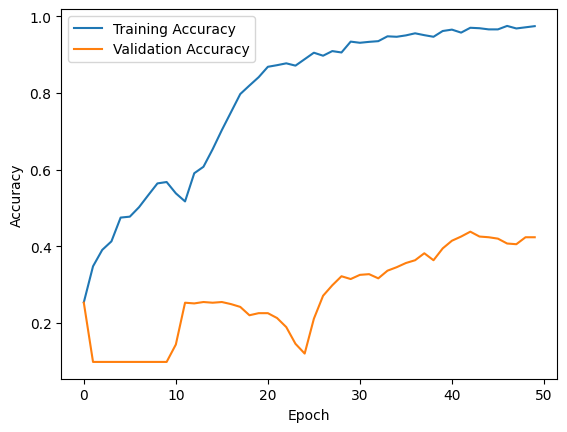

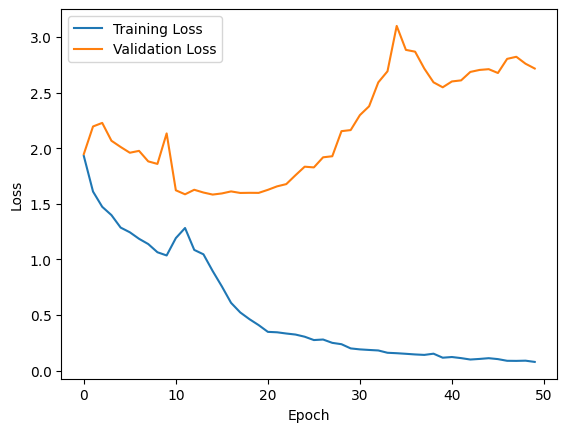

In [63]:
plot_training_history(history)

In [64]:
efn_model.save('/content/drive/MyDrive/Diabetic-Retinopathy-Detection Models/EfficientNet.h5')

# Model Building & Training VGG16

## Importing VGG Model (Transfer Learning)

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

## Building The CNN Architicture

In [ ]:
model_vgg = Sequential()
model_vgg.add(vgg_model)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.2))
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.2))
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(64, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(32, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(16, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(5, activation='softmax'))

In [ ]:
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)              

## Model Compiling

In [ ]:
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

## Model Fitting

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-6, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

history = model_vgg.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[reduce_lr, early_stop]
    )

<ipython-input-22-e2f53e4c3bdd>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_vgg.fit_generator(


Epoch 1/50
20/20 [==============================] - 62s 2s/step - loss: 1.6092 - acc: 0.2305 - val_loss: 1.5778 - val_acc: 0.2555 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 28s 1s/step - loss: 1.5929 - acc: 0.2381 - val_loss: 1.5855 - val_acc: 0.2555 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 28s 1s/step - loss: 1.5832 - acc: 0.2356 - val_loss: 1.5622 - val_acc: 0.2555 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 28s 1s/step - loss: 1.5834 - acc: 0.2584 - val_loss: 1.5696 - val_acc: 0.2555 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 28s 1s/step - loss: 1.5730 - acc: 0.2381 - val_loss: 1.5606 - val_acc: 0.2555 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 28s 1s/step - loss: 1.5769 - acc: 0.2343 - val_loss: 1.5701 - val_acc: 0.2555 - lr: 0.0010
Epoch 7/50
20/20 [==============================] - 31s 2s/step - loss: 1.5701 - acc: 0.2451 - val_loss: 1.5576 - val_acc: 0.2555 - lr: 0.0010

## Save The Model & The Weights

In [ ]:
model_vgg.save('/content/drive/MyDrive/Diabetic-Retinopathy-Detection Models/VGG16.h5')

In [ ]:
MODEL_PATH = os.path.join("Diabetic_Retinopathy_Detector(VGG16).h5")
MODEL_WEIGHTS_PATH = os.path.join("Diabetic_Retinopathy_Model_Weights(VGG16).h5")
model_vgg.save(MODEL_PATH)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Uploading the Model to Github Repo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copy('/content/Diabetic_Retinopathy_Detector(VGG16).h5', '/content/drive/My Drive/Diabetic_Retinopathy_Detector(VGG16).h5')

'/content/drive/My Drive/Diabetic_Retinopathy_Detector(VGG16).h5'

In [ ]:
!git clone https://github.com/AnSaradar/Diabetic-Retinopathy-Detection

Cloning into 'Diabetic-Retinopathy-Detection'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 243.57 KiB | 20.30 MiB/s, done.


In [ ]:
!mv '/content/drive/My Drive/Diabetic_Retinopathy_Detector(VGG16).h5' '/content/Diabetic-Retinopathy-Detection'

In [ ]:
!cd /content/Diabetic-Retinopathy-Detection
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [ ]:

!git add .
!git commit -m "Add trained model files"
!git push origin master

hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> Diabetic-Retinopathy-Detection
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached Diabetic-Retinopathy-Detection
hint: 
hint: See "git help submodule" for more information.
error: open("drive/MyDrive/2nd Lecture - STL.gdoc"): Operation not supported
error: unable to index file 'drive/MyDrive/2nd Lecture - STL.gdoc'
fatal: adding files failed
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect emai

## Testing The Model

In [ ]:
test_loss, test_accuracy = model_vgg.evaluate(test_generator, steps=test_generator.n // batch_size)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 6s 85ms/step - loss: 1.3927 - acc: 0.0000e+00
Test Accuracy: 0.0


## Training & Validation Curve

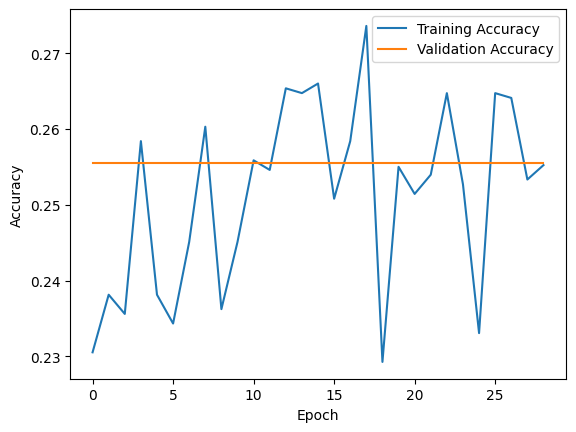

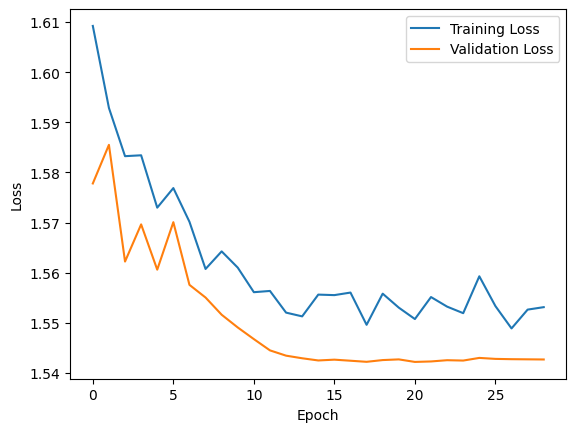

In [ ]:
plot_training_history(history)

# Model Building & Training RESNET50

## Import The RESNET 50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


## Building the Model Architcture

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model_resnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Model Training

In [ ]:
history = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size)

Epoch 1/50
20/20 [==============================] - 33s 2s/step - loss: 1.5988 - accuracy: 0.2457 - val_loss: 1.5549 - val_accuracy: 0.2555
Epoch 2/50
20/20 [==============================] - 28s 1s/step - loss: 1.5868 - accuracy: 0.2481 - val_loss: 1.5773 - val_accuracy: 0.2555
Epoch 3/50
20/20 [==============================] - 29s 1s/step - loss: 1.5808 - accuracy: 0.2717 - val_loss: 1.5782 - val_accuracy: 0.2555
Epoch 4/50
20/20 [==============================] - 31s 2s/step - loss: 1.6223 - accuracy: 0.2445 - val_loss: 1.6282 - val_accuracy: 0.2555
Epoch 5/50
20/20 [==============================] - 28s 1s/step - loss: 1.5874 - accuracy: 0.2679 - val_loss: 1.5537 - val_accuracy: 0.2463
Epoch 6/50
20/20 [==============================] - 28s 1s/step - loss: 1.5712 - accuracy: 0.2525 - val_loss: 1.5654 - val_accuracy: 0.2482
Epoch 7/50
20/20 [==============================] - 29s 1s/step - loss: 1.5651 - accuracy: 0.2590 - val_loss: 1.5619 - val_accuracy: 0.2537
Epoch 8/50
20/20 [==

## Model Evaluation

In [ ]:
test_loss, test_acc = model_resnet.evaluate(test_generator, steps=test_generator.samples//batch_size)
print('Test accuracy:', test_acc)

17/17 [==============================] - 3s 91ms/step - loss: 1.3000 - accuracy: 0.5490
Test accuracy: 0.5490196347236633


## Training & Validation Curve

In [ ]:
def plot_training_history_RESNET50(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

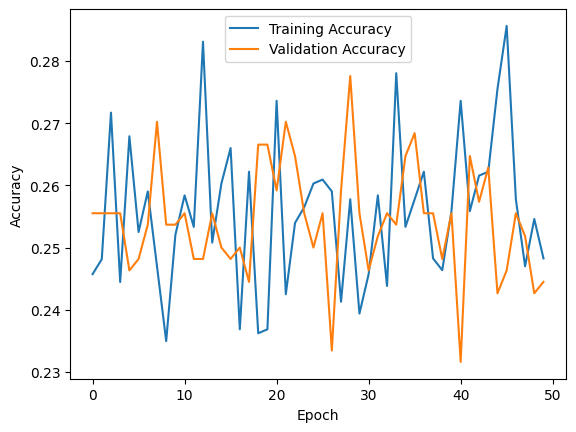

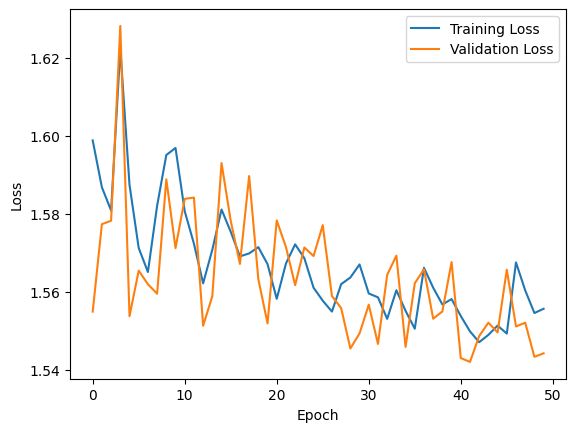

In [ ]:
plot_training_history_RESNET50(history)

Mode

In [ ]:
MODEL_PATH = os.path.join("Diabetic_Retinopathy_Detector(RESNET50).h5")
MODEL_WEIGHTS_PATH = os.path.join("Diabetic_Retinopathy_Model_Weights(RESNET50).h5")
model_resnet.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Streamlit Buildup

## Model Loading

In [ ]:
!pip install -q pyngrok

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1MXyuPz3ICvaAanL0foIvJJkI-GCea3eZ'
output = 'VGG16.h5'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1MXyuPz3ICvaAanL0foIvJJkI-GCea3eZ
From (redirected): https://drive.google.com/uc?id=1MXyuPz3ICvaAanL0foIvJJkI-GCea3eZ&confirm=t&uuid=2684801d-379c-4860-bc34-c715d30554bb
To: /content/VGG16.h5
100%|██████████| 194M/194M [00:00<00:00, 224MB/s]


'VGG16.h5'

In [ ]:
from pyngrok import ngrok ,conf
import streamlit as st
import os
import getpass

In [ ]:
app_code = """
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
import gdown


def predict(image, model):

    image = image / 255.0

    prediction = model.predict(np.expand_dims(image, axis=0))

    return prediction

def main():

    st.title('Diabetic Retinopathy Detection App')

    model = tf.keras.models.load_model('/content/VGG16.h5')

    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption='Uploaded Image.', use_column_width=True)

        if st.button('Predict'):

            prediction = predict(image, model)

            st.write("Model Prediction:", prediction)

if __name__ == "__main__":
    main()

    """

In [ ]:
with open("diabetic_retinopathy_app.py", "w") as f:
    f.write(app_code)

# Start Streamlit
!nohup streamlit run diabetic_retinopathy_app.py &

print("Enter ur AUTH from https://dashboard.ngrok.com/auth")
#2Qt0zIDV6eUueAYnaYWjPdRXLpj_6WQqVKexKPYf9UKUCLZ6T
conf.get_default().auth_token = getpass.getpass()
port = 5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \ "{public_url}\" -> \"https://127.0.0.1:{port}\"')

In [ ]:
%%writefile diabetic_retinopathy_app.py
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
import gdown


def predict(image, model):

    image = image / 255.0

    prediction = model.predict(np.expand_dims(image, axis=0))

    return prediction

def main():

    st.title('Diabetic Retinopathy Detection App')

    model = tf.keras.models.load_model('/content/VGG16.h5')

    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption='Uploaded Image.', use_column_width=True)

        if st.button('Predict'):

            prediction = predict(image, model)

            st.write("Model Prediction:", prediction)

if __name__ == "__main__":
    main()

Overwriting diabetic_retinopathy_app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 1.348s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
!streamlit run diabetic_retinopathy_app.py &>/content/logs.txt &

In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8503
  External URL: http://34.143.173.173:8503

  Stopping...
  Stopping...


In [ ]:
!npx localtunnel --port 8501

^C


# Try your own image

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def classify_image(image_url, model):

    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    img = img.resize((150, 150))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    class_probabilities = model.predict(img_array)
    predicted_class = np.argmax(class_probabilities)

    return predicted_class

In [ ]:
image_url = "URL_OF_YOUR_IMAGE"
predicted_class = classify_image(image_url, model_vgg)
print("Predicted Class:", predicted_class)